In [1]:
!pip install -U pip setuptools wheel
!pip install jupyter pandas numpy matplotlib seaborn scikit-learn imbalanced-learn xgboost lightgbm imbalanced-learn
!pip install kagglehub

In [2]:
%matplotlib inline
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt


sns.set(style="whitegrid")

In [3]:
#To download datset from Kaggle:
import kagglehub
from pathlib import Path
import pandas as pd

path = kagglehub.dataset_download("fedesoriano/stroke-prediction-dataset") 
print("Path to dataset files:", path)

Path to dataset files: /Users/leilatawfik/.cache/kagglehub/datasets/fedesoriano/stroke-prediction-dataset/versions/1


In [4]:
p= Path(path)
df = pd.read_csv(p / "healthcare-dataset-stroke-data.csv")
print(df.head())

      id  gender   age  hypertension  heart_disease ever_married  \
0   9046    Male  67.0             0              1          Yes   
1  51676  Female  61.0             0              0          Yes   
2  31112    Male  80.0             0              1          Yes   
3  60182  Female  49.0             0              0          Yes   
4   1665  Female  79.0             1              0          Yes   

       work_type Residence_type  avg_glucose_level   bmi   smoking_status  \
0        Private          Urban             228.69  36.6  formerly smoked   
1  Self-employed          Rural             202.21   NaN     never smoked   
2        Private          Rural             105.92  32.5     never smoked   
3        Private          Urban             171.23  34.4           smokes   
4  Self-employed          Rural             174.12  24.0     never smoked   

   stroke  
0       1  
1       1  
2       1  
3       1  
4       1  


           count  percent
stroke                   
No stroke   4861    95.13
Stroke       249     4.87
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5110 entries, 0 to 5109
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   id                 5110 non-null   int64  
 1   gender             5110 non-null   object 
 2   age                5110 non-null   float64
 3   hypertension       5110 non-null   int64  
 4   heart_disease      5110 non-null   int64  
 5   ever_married       5110 non-null   object 
 6   work_type          5110 non-null   object 
 7   Residence_type     5110 non-null   object 
 8   avg_glucose_level  5110 non-null   float64
 9   bmi                5110 non-null   float64
 10  smoking_status     5110 non-null   object 
 11  stroke             5110 non-null   int64  
dtypes: float64(3), int64(4), object(5)
memory usage: 479.2+ KB
        gender          age  hypertension  heart_dise

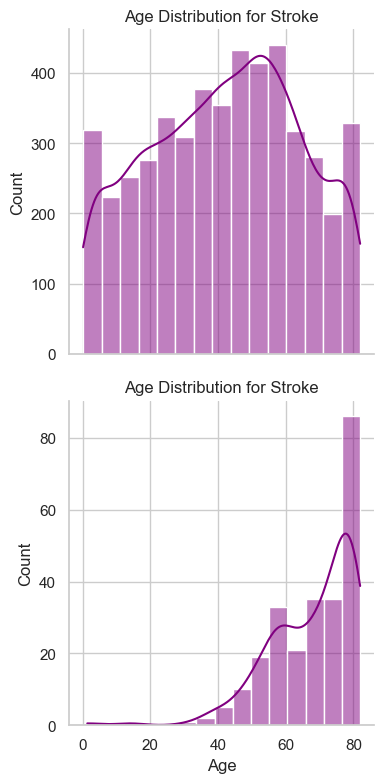

In [5]:




#PREPROCESSING STEPS
#Create new DataFrame without missing BMI values
df ["bmi"] = df["bmi"].fillna(df["bmi"].median()) #Imputation of BMI values

#Stroke vs No stroke
dist = df["stroke"].value_counts().sort_index()
pct  = (df["stroke"].value_counts(normalize=True).sort_index() * 100).round(2)
summary = pd.DataFrame({"count": dist, "percent": pct}).rename(index={0:"No stroke", 1:"Stroke"})
print(summary)

#Data types and null value info:
df.info()

#Removing dupliactes
df.drop_duplicates(inplace = True)

#Drop ID column
df.drop(columns=['id'], inplace=True, errors='ignore')


#Description of stats
print (df.describe (include = "all"))

#How many missing values exist in each column
print (df.isnull().sum())


#Change categorical data into numerical values
if "gender" in df.columns:
    df = df[df["gender"].isin(["Male", "Female"])].copy()
df.drop(columns=["gender_num"], inplace=True, errors="ignore")

if "gender" in df.columns and not any(c.startswith("gender_") for c in df.columns):
    df = pd.get_dummies(df, columns=["gender"], drop_first=False)

for c in ["gender_Male", "gender_Female"]:
    if c in df.columns:
        df[c] = pd.to_numeric(df[c], errors="coerce").astype(float)







if "ever_married" in df.columns and "is_ever_married" not in df.columns:
  df['is_ever_married'] = df['ever_married'].map({'No':0,'Yes':1})
df.drop(columns=["ever_married"], inplace=True, errors="ignore")
if "Residence_type" in df.columns and "is_urban" not in df.columns:
  df['is_urban'] = df['Residence_type'].map({'Rural':0,'Urban':1})
df.drop(columns=["Residence_type"], inplace=True, errors="ignore")
if "work_type" in df.columns and not any(c.startswith("work_type_") for c in df.columns):
    df = pd.get_dummies(df, columns=["work_type"], drop_first=True)
if "smoking_status" in df.columns and not any(c.startswith("smoking_status_") for c in df.columns):
    df = pd.get_dummies(df, columns=["smoking_status"], drop_first=True)



#To make sure NaN doesn't show up in our binary values:
int_like_cols = ["hypertension", "heart_disease", "stroke",
                 "gender_num", "is_ever_married", "is_urban"]
for col in int_like_cols:
    if col in df.columns:
        df[col] = pd.to_numeric(df[col], errors="coerce").astype("Int64")

#Print overall values
print ("Final columns:", list (df.columns))

#Print missing values
print (df.isnull().sum())

#Checking for class imbalances
if "stroke" in df.columns:
    vc = df["stroke"].value_counts().sort_index() #---> any class imbalances here will be printed as a percentage
    pct = (vc / len(df) * 100). round(2)
    print(pd.DataFrame({"count": vc, "percent": pct}))
else:
    print("column 'stroke' not found.")

#Checking for extremes in the dataset
for col in ["avg_glucose_level", "bmi"]:
    if col in df.columns:
        d = df[col].describe()
        print (f"{col}: min={d['min']: .2f}, 25%={d['25%']:.2f}, median={d['50%']:.2f}, 75%={d['75%']:.2f}, max={d['max']:.2f}")
    else:
        print(f"{col}: not in dataframe")


#Overview of age and gender demographics
if "age" in df.columns:
    d = df["age"].describe()
    print(f"Age --> mean={d['mean']:.2f}, std={d['std']:.2f}, min={d['min']:.2f}, max={d['max']:.2f}")

if "gender" in df.columns: #---> gender here is changed to a % distribution
    print("\nGender distribution (%):")
    print((df["gender"].value_counts(normalize=True) * 100).round(2))

#Top Correlations
num = df.select_dtypes(include="number").copy()
corr = num.corr()
mask = np.triu(np.ones_like(corr, dtype=bool), k=1)
pairs = corr.where(mask).stack().rename("corr")
print("\nTop 5 strongest correlations (signed):")
print(pairs.reindex(pairs.abs().sort_values(ascending=False).index).head(5).round(3))

print("\nBottom 5 weakest correlations (signed):")
print(pairs.reindex(pairs.abs().sort_values(ascending=True).index).head(5).round(3))


# Create a FacetGrid for multiple histograms
g = sns.FacetGrid(df, col="stroke", col_wrap=1, height=4, sharex=True, sharey=False)
g.map(sns.histplot, "age", kde=True, bins=15, color="purple")

# Add titles
g.set_axis_labels("Age", "Count")
g.set_titles("Age Distribution for Stroke")

# Show plot
plt.tight_layout()
plt.show()

In [6]:
#i just changed this to another cell so i can run it wihtout running the model
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import StratifiedKFold, train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, f1_score, average_precision_score, roc_auc_score, confusion_matrix

In [7]:

#Statistical tests to find best evaluation metrics 

#Fairness measures:

def get_gender_series(X: pd.DataFrame) -> np.ndarray:   #For fairness, reconstructing one hot encoding so evaluate gender and ensure no original labels were lost
    if "gender" in X.columns:
        return X["gender"].astype(str).values
    if "gender_Female" in X.columns:
        return np.where(X["gender_Female"].values > 0.5, "Female", "Male")
    return np.array(["Unknown"]* len(X))

def statistical_parity_difference(y_pred: np.ndarray, gender: np.ndarray) -> float: #Statistical parity difference for fairness check to find if model flags one group mroe than another
    m_f = (gender == "Female")
    m_m = (gender == "Male")
    if not m_f.any() or not m_m.any():
        return np.nan
    return y_pred[m_f].mean() - y_pred[m_m].mean()


#Feature engineering targets for the model
data = df.copy()

if "gender" in data.columns: #if any gender columns still exist, convert to male or female
    data = data[data["gender"].isin(["Male", "Female"])]


#Model target
data["stroke"] = pd.to_numeric(data["stroke"], errors="coerce").fillna(0).astype(int)
y = data["stroke"].values
X = data.drop(columns=["stroke"])

#Data classification as numeric, binary or categorical 
numeric_features = [c for c in ["age", "avg_glucose_level", "bmi"] if c in X.columns]
binary_features  = [c for c in ["hypertension", "heart_disease"] if c in X.columns]
categorical_features = X.select_dtypes(include=["object", "category"]).columns.tolist()

#Leak based processing to ensure preprocessing statistics is only done on the training data and can be used for validation tests
numeric_tfm = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler())
])

categorical_tfm = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("onehot", OneHotEncoder(handle_unknown="ignore"))
])

preprocessor = ColumnTransformer(
    transformers=[
        ("num", numeric_tfm, numeric_features),
        ("cat", categorical_tfm, categorical_features),
        ("bin", "passthrough", binary_features)
    ],
    remainder="drop"
)

#Defining our model
model = LogisticRegression(
    class_weight="balanced",  # important with ~5% positives
    solver="liblinear",
    max_iter=200,
    random_state=42
)

clf = Pipeline(steps=[("prep", preprocessor), ("model", model)])

#10 fold K test and SPD
skf = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)

f1s, accs, pr_aucs, roc_aucs, spds = [], [], [], [], []

for fold, (tr, te) in enumerate(skf.split(X, y), start=1):
    X_tr, X_te = X.iloc[tr], X.iloc[te]
    y_tr, y_te = y[tr], y[te]

    # Save raw gender for fairness --> one hot encode gender was used in pipeline, here membership is needed per row
    gender_te = get_gender_series(X_te)

    # Fit on train, predict on test
    clf.fit(X_tr, y_tr)
    y_scores = clf.predict_proba(X_te)[:, 1]
    y_pred = (y_scores >= 0.5).astype(int)  # simple default threshold

    # Accuracy metrics
    accs.append(accuracy_score(y_te, y_pred))
    f1s.append(f1_score(y_te, y_pred, zero_division=0))
    pr_aucs.append(average_precision_score(y_te, y_scores))  # PR-AUC
    roc_aucs.append(roc_auc_score(y_te, y_scores))           # optional

    # Fairness statistical parity difference 
    spds.append(statistical_parity_difference(y_pred, gender_te))



#Print Output
def mean_std(a): 
    return f"{np.mean(a):.3f} ± {np.std(a):.3f}"

print("\n 10-fold results (mean ± std)")
print(f"Accuracy : {mean_std(accs)}")
print(f"F1-score : {mean_std(f1s)}")
print(f"PR-AUC   : {mean_std(pr_aucs)}")
print(f"ROC-AUC  : {mean_std(roc_aucs)}")
print(f"SPD (Female - Male) : {mean_std(spds)}")

#^^ turn that into table data for presentation




 10-fold results (mean ± std)
Accuracy : 0.735 ± 0.014
F1-score : 0.224 ± 0.025
PR-AUC   : 0.215 ± 0.047
ROC-AUC  : 0.842 ± 0.023
SPD (Female - Male) : -0.015 ± 0.055


In [8]:
from xgboost import XGBClassifier
import joblib

In [34]:
#random forest classifer model
y = data["stroke"]           
X = data.drop(columns=["stroke"])  

#80/20 test/train split
#stratifying the data for equal distribution of classes between test and training data
#random state for reproducibility 
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

X_train = X_train.reset_index(drop=True)
y_train = y_train.reset_index(drop=True)

#k-fold stratification for X_train
#10 folds, and the training and validation sets are shuffled
skf = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)

#empty lists for the results of each fold 

fold_results = []
fold_to_save = 10
fold = 1

#training and validation loops, with model fitting and evaluation
for train_index, val_index in skf.split(X_train, y_train):

    X_tr = X_train.iloc[train_index]
    X_val = X_train.iloc[val_index]
    y_tr = y_train.iloc[train_index]
    y_val = y_train.iloc[val_index]

    rf = RandomForestClassifier(
        n_estimators=300, 
        max_depth=None, 
        class_weight='balanced', 
        random_state=42
    )

    # train on the fold training data
    rf.fit(X_tr, y_tr)
    y_pred = rf.predict(X_val)

    accs = accuracy_score(y_val, y_pred)
    f1s = f1_score(y_val, y_pred, zero_division=0)
    pr_aucs = average_precision_score(y_val, y_pred)
    roc_aucs = roc_auc_score(y_val, y_pred)

    print(f"\nFold {fold}: Accuracy={accs:.2f}, F1={f1s:.2f}, PR_AUC={pr_aucs:.2f}, ROC_AUC={roc_aucs:.2f}")

    fold_results.append({
        "fold": fold,
        "accuracy": accs,
        "f1": f1s,
        "pr_auc": pr_aucs, 
        "roc_auc": roc_aucs
    })

    if fold == fold_to_save:
        joblib.dump(rf, f"fold_{fold}_models_rf.pkl")
        print(f"Fold {fold} model saved as fold_{fold}_models_rf.pkl")

    fold += 1

# summary
def mean_std(a): 
    return f"{np.mean(a):.3f} ± {np.std(a):.3f}"

print("\n10-fold results RFC (mean ± std)")
print(f"Accuracy : {mean_std([r['accuracy'] for r in fold_results])}")
print(f"F1-score : {mean_std([r['f1']      for r in fold_results])}")
print(f"PR-AUC   : {mean_std([r['pr_auc']  for r in fold_results])}")
print(f"ROC-AUC  : {mean_std([r['roc_auc'] for r in fold_results])}")





Fold 1: Accuracy=0.95, F1=0.00, PR_AUC=0.05, ROC_AUC=0.50

Fold 2: Accuracy=0.95, F1=0.00, PR_AUC=0.05, ROC_AUC=0.50

Fold 3: Accuracy=0.95, F1=0.00, PR_AUC=0.05, ROC_AUC=0.50

Fold 4: Accuracy=0.95, F1=0.00, PR_AUC=0.05, ROC_AUC=0.50

Fold 5: Accuracy=0.95, F1=0.00, PR_AUC=0.05, ROC_AUC=0.50

Fold 6: Accuracy=0.95, F1=0.00, PR_AUC=0.05, ROC_AUC=0.50

Fold 7: Accuracy=0.95, F1=0.00, PR_AUC=0.05, ROC_AUC=0.50

Fold 8: Accuracy=0.95, F1=0.00, PR_AUC=0.05, ROC_AUC=0.50

Fold 9: Accuracy=0.95, F1=0.00, PR_AUC=0.05, ROC_AUC=0.50

Fold 10: Accuracy=0.95, F1=0.00, PR_AUC=0.05, ROC_AUC=0.50
Fold 10 model saved as fold_10_models_rf.pkl

10-fold results RFC (mean ± std)
Accuracy : 0.951 ± 0.001
F1-score : 0.000 ± 0.000
PR-AUC   : 0.049 ± 0.001
ROC-AUC  : 0.500 ± 0.001


In [35]:
#testign with random forest
fold10_modelT_rf = joblib.load("fold_10_models_rf.pkl")
print(f"{fold10_modelT_rf} loaded successfully!")

RandomForestClassifier(class_weight='balanced', n_estimators=300,
                       random_state=42) loaded successfully!


In [22]:
X_test = X_test.reset_index(drop=True)
y_test = y_test.reset_index(drop=True)

In [36]:
#testing with fold 10 random forest
y_pred = fold10_modelT_rf.predict(X_test)
y_prob = fold10_modelT_rf.predict_proba(X_test)[:, 1]

print("Final Hold-out Test Evaluation (Fold 10 RF model):")
print(f"Accuracy: {accuracy_score(y_test, y_pred):.3f}")
print(f"F1 Score: {f1_score(y_test, y_pred):.3f}")
print(f"PR AUC: {average_precision_score(y_test, y_prob):.3f}")
print(f"ROC AUC: {roc_auc_score(y_test, y_prob):.3f}")

Final Hold-out Test Evaluation (Fold 10 RF model):
Accuracy: 0.950
F1 Score: 0.000
PR AUC: 0.145
ROC AUC: 0.792


In [37]:
#trying a different model here -XGBoost

#dictionary used to save each fold model 
fold_models = {}

#empty list for the results of each fold 
fold_results_xgboost = []
fold_to_save = 8
fold = 1

X_test = X_test.reset_index(drop=True)
y_test = y_test.reset_index(drop=True)

#sample weight to handle class imbalance
pos_weight = (len(y_train) - sum(y_train)) / sum(y_train)

#training and validation loops, with model fitting and evaluation
for train_index, val_index in skf.split(X_train, y_train):

    X_tr = X_train.iloc[train_index]
    X_val = X_train.iloc[val_index]
    y_tr = y_train.iloc[train_index]
    y_val = y_train.iloc[val_index]

    xgb_model = XGBClassifier(
        n_estimators=200, 
        max_depth=5,
        learning_rate=0.05,
        eval_metric='logloss',
        colsample_bytree=0.8,
        scale_pos_weight=pos_weight,
        random_state=42,
        n_jobs=1
    )

    xgb_model.fit(X_tr, y_tr)
    y_pred = xgb_model.predict(X_val)

    accs = accuracy_score(y_val, y_pred)
    f1s = f1_score(y_val, y_pred, zero_division=0)
    pr_aucs = average_precision_score(y_val, y_pred)
    roc_aucs = roc_auc_score(y_val, y_pred)

    print(f"\nFold {fold}: Acc={accs:.2f}, F1={f1s:.2f}, PR_AUC={pr_aucs:.2f}, ROC_AUC={roc_aucs:.2f}")

    fold_results_xgboost.append({
        "fold": fold,
        "accuracy": accs,
        "f1": f1s,
        "pr_auc": pr_aucs,
        "roc_auc": roc_aucs
    })

    fold += 1

    if fold == fold_to_save:
        joblib.dump(xgb_model, f"fold_{fold}_models.pkl")
        print(f"Fold {fold} model saved as fold_{fold}_models.pkl")

#print average for each metric across all folds
def mean_std(a):
    return f"{np.mean(a):.3f} ± {np.std(a):.3f}"
print("\n 10-fold results (mean ± std)")
print(f"Accuracy : {mean_std(accs)}")
print(f"F1-score : {mean_std(f1s)}")
print(f"PR-AUC   : {mean_std(pr_aucs)}")
print(f"ROC-AUC  : {mean_std(roc_aucs)}")




Fold 1: Acc=0.86, F1=0.29, PR_AUC=0.14, ROC_AUC=0.74

Fold 2: Acc=0.86, F1=0.30, PR_AUC=0.14, ROC_AUC=0.74

Fold 3: Acc=0.87, F1=0.25, PR_AUC=0.11, ROC_AUC=0.67

Fold 4: Acc=0.87, F1=0.31, PR_AUC=0.14, ROC_AUC=0.74

Fold 5: Acc=0.87, F1=0.25, PR_AUC=0.11, ROC_AUC=0.67

Fold 6: Acc=0.86, F1=0.29, PR_AUC=0.14, ROC_AUC=0.74

Fold 7: Acc=0.85, F1=0.18, PR_AUC=0.07, ROC_AUC=0.61
Fold 8 model saved as fold_8_models.pkl

Fold 8: Acc=0.86, F1=0.19, PR_AUC=0.08, ROC_AUC=0.62

Fold 9: Acc=0.85, F1=0.21, PR_AUC=0.08, ROC_AUC=0.64

Fold 10: Acc=0.86, F1=0.26, PR_AUC=0.11, ROC_AUC=0.69

 10-fold results (mean ± std)
Accuracy : 0.858 ± 0.000
F1-score : 0.256 ± 0.000
PR-AUC   : 0.111 ± 0.000
ROC-AUC  : 0.688 ± 0.000


In [38]:
#trying a different fold model here -XGBoost
fold8_modelT = joblib.load("fold_8_models.pkl")
print(f"{fold8_modelT} loaded successfully!")

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.8, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, feature_weights=None, gamma=None,
              grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.05, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=5, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=200, n_jobs=1,
              num_parallel_tree=None, ...) loaded successfully!


In [39]:
#testing with fold 7
y_pred = fold8_modelT.predict(X_test)
y_prob = fold8_modelT.predict_proba(X_test)[:, 1]

print("Final Hold-out Test Evaluation (Fold 8 model):")
print(f"Accuracy: {accuracy_score(y_test, y_pred):.3f}")
print(f"F1 Score: {f1_score(y_test, y_pred):.3f}")
print(f"PR AUC: {average_precision_score(y_test, y_prob):.3f}")
print(f"ROC AUC: {roc_auc_score(y_test, y_prob):.3f}")


Final Hold-out Test Evaluation (Fold 8 model):
Accuracy: 0.861
F1 Score: 0.260
PR AUC: 0.218
ROC AUC: 0.825


In [40]:
#trying XGBoost model with SMOTE to oversample the minority class

fold_models = {}    #dictionary used to save each fold model 
fold_results_xgboost = []   #empty list for the results of each fold 
fold = 1    #starting fold count

#converting all integer columns to float for SMOTE compatibility
for col in X_train.columns:
    if X_train[col].dtype.name in ["Int64", "int32", "int64", "bool"]:
        X_train[col] = X_train[col].astype("float64")

fold_to_save = 8

# Reset test set indexes 
X_test = X_test.reset_index(drop=True)
y_test = y_test.reset_index(drop=True)

for train_index, val_index in skf.split(X_train, y_train):

    # Split fold-specific data
    X_tr = X_train.iloc[train_index].reset_index(drop=True)
    X_val = X_train.iloc[val_index].reset_index(drop=True)
    y_tr = y_train.iloc[train_index].reset_index(drop=True)
    y_val = y_train.iloc[val_index].reset_index(drop=True)

    # Smote on training fold
    smote = SMOTE(random_state=42)
    X_tr_res, y_tr_res = smote.fit_resample(X_tr, y_tr)

    xgb_model = XGBClassifier(
        n_estimators=200,
        max_depth=5,
        learning_rate=0.05,
        eval_metric='logloss',
        colsample_bytree=0.8,
        random_state=42,
        n_jobs=1
    )

    # Train on resampled data
    xgb_model.fit(X_tr_res, y_tr_res)

    # Predict on validation fold
    y_pred = xgb_model.predict(X_val)

    # Evaluate fold performance
    accs = accuracy_score(y_val, y_pred)
    f1s = f1_score(y_val, y_pred, zero_division=0)
    pr_aucs = average_precision_score(y_val, y_pred)
    roc_aucs = roc_auc_score(y_val, y_pred)

    print(f"\nFold {fold}: Acc={accs:.3f}, F1={f1s:.3f}, PR_AUC={pr_aucs:.3f}, ROC_AUC={roc_aucs:.3f}")

    # Save results
    fold_results_xgboost.append({
        "fold": fold,
        "accuracy": accs,
        "f1": f1s,
        "pr_auc": pr_aucs,
        "roc_auc": roc_aucs
    })

    # Save model at requested fold
    if fold == fold_to_save:
        joblib.dump(xgb_model, f"fold_{fold}_model_SMOTE.pkl")
        print(f"Fold {fold} model saved as fold_{fold}_model_SMOTE.pkl")

    fold += 1

#average metrics    
accs_list = [d["accuracy"] for d in fold_results_xgboost]
f1_list   = [d["f1"]       for d in fold_results_xgboost]
pr_list   = [d["pr_auc"]   for d in fold_results_xgboost]
roc_list  = [d["roc_auc"]  for d in fold_results_xgboost]

def mean_std(a):
    return f"{np.mean(a):.3f} ± {np.std(a):.3f}"

print("\n10-FOLD RESULTS (mean ± std)")
print(f"Accuracy : {mean_std(accs_list)}")
print(f"F1-score : {mean_std(f1_list)}")
print(f"PR-AUC   : {mean_std(pr_list)}")
print(f"ROC-AUC  : {mean_std(roc_list)}")


Fold 1: Acc=0.954, F1=0.174, PR_AUC=0.111, ROC_AUC=0.549

Fold 2: Acc=0.944, F1=0.000, PR_AUC=0.049, ROC_AUC=0.496

Fold 3: Acc=0.946, F1=0.083, PR_AUC=0.059, ROC_AUC=0.521

Fold 4: Acc=0.946, F1=0.000, PR_AUC=0.049, ROC_AUC=0.497

Fold 5: Acc=0.941, F1=0.000, PR_AUC=0.049, ROC_AUC=0.495

Fold 6: Acc=0.954, F1=0.095, PR_AUC=0.096, ROC_AUC=0.525

Fold 7: Acc=0.949, F1=0.087, PR_AUC=0.063, ROC_AUC=0.522

Fold 8: Acc=0.951, F1=0.000, PR_AUC=0.047, ROC_AUC=0.499
Fold 8 model saved as fold_8_model_SMOTE.pkl

Fold 9: Acc=0.951, F1=0.000, PR_AUC=0.049, ROC_AUC=0.500

Fold 10: Acc=0.951, F1=0.000, PR_AUC=0.049, ROC_AUC=0.500

10-FOLD RESULTS (mean ± std)
Accuracy : 0.949 ± 0.004
F1-score : 0.044 ± 0.059
PR-AUC   : 0.062 ± 0.022
ROC-AUC  : 0.510 ± 0.017


In [43]:
#XGBoost model with SMOTE - loading fold 8 model
#using model with best PR_AUC
fold8_modelT_SMOTE = joblib.load("fold_8_model_SMOTE.pkl")
print(f"{fold8_modelT_SMOTE} loaded successfully!")

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.8, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, feature_weights=None, gamma=None,
              grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.05, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=5, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=200, n_jobs=1,
              num_parallel_tree=None, ...) loaded successfully!


In [44]:
print(pd.Series(y_pred).value_counts())

0    408
Name: count, dtype: int64


In [45]:
X_test_for_pred = X_test.drop(columns=["age_group"], errors="ignore")

y_pred = fold8_modelT_rebal.predict(X_test_for_pred)
y_prob = fold8_modelT_rebal.predict_proba(X_test_for_pred)[:, 1]

print(f"Final Hold-out Test Evaluation:")
print(f"Accuracy: {accuracy_score(y_test, y_pred):.3f}")
print(f"F1 Score: {f1_score(y_test, y_pred):.3f}")
print(f"PR AUC: {average_precision_score(y_test, y_prob):.3f}")
print(f"ROC AUC: {roc_auc_score(y_test, y_prob):.3f}")

Final Hold-out Test Evaluation:
Accuracy: 0.949
F1 Score: 0.103
PR AUC: 0.185
ROC AUC: 0.794


In [46]:
X_test = X_test.reset_index(drop=True)
y_test = y_test.reset_index(drop=True)
y_pred = pd.Series(y_pred).reset_index(drop=True)

#fairness metrics for age group: 
X_test["age_group"] = pd.cut(
    X_test["age"],
    bins=[0, 39, 100],   # younger <40, older ≥40 (you can adjust)
    labels=["young", "old"])

#NPV = TN / (TN + FN)

def negative_predictive_value(y_true, y_pred):
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred, labels=[0,1]).ravel()
    return tn / (tn + fn) if (tn + fn) > 0 else 0

def false_negative_rate(y_true, y_pred):
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred, labels=[0,1]).ravel()
    return fn / (fn + tp) if (fn + tp) > 0 else 0

results_fairness = {}

groups_fairness = {
    "young": X_test["age_group"] == "young",
    "old":   X_test["age_group"] == "old",
    "male":  X_test["gender_Male"] == 1,
    "female":X_test["gender_Female"] == 1
}

for group_name, mask in groups_fairness.items():
    y_true_g = y_test[mask]
    y_pred_g = pd.Series(y_pred, index=y_test.index)[mask]

    npv = negative_predictive_value(y_true_g, y_pred_g)
    fnr = false_negative_rate(y_true_g, y_pred_g)

    results_fairness[group_name] = {
        "NPV": npv,
        "FNR": fnr
    }

results_df = pd.DataFrame(results_fairness).T
results_df




,NPV,FNR
young,0.988479,1.000000
old,0.927586,0.933333
male,0.954762,0.904762
female,0.952862,0.965517


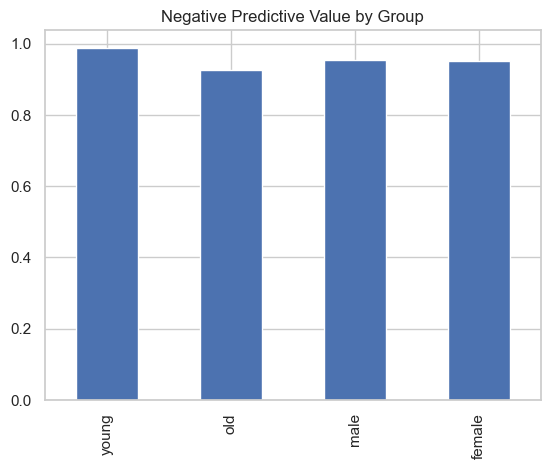

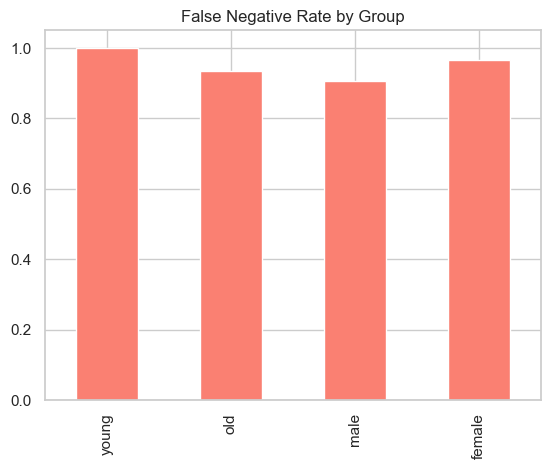

In [47]:
#need to change this to a horizontal bar chart for better visualization
results_df["NPV"].plot(kind="bar", title="Negative Predictive Value by Group")
plt.show()

#range of y value should be 1.0 to 0.0
results_df["FNR"].plot(kind="bar", title="False Negative Rate by Group", color="salmon")
plt.show()

In [48]:
#explainability with SHAP
!pip install shap
import shap

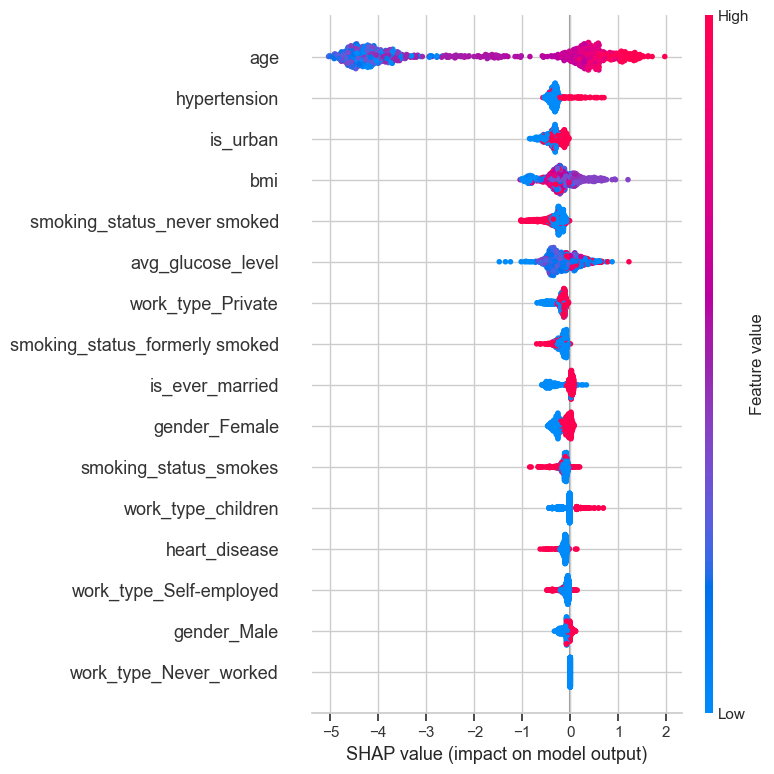

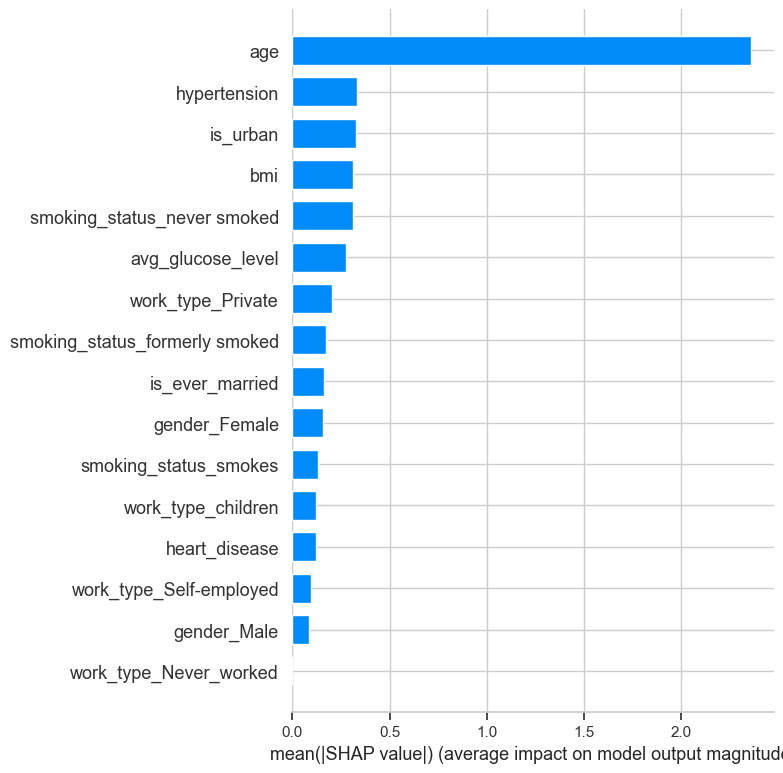

In [51]:
X_test_for_pred = X_test.drop(columns=["age_group"], errors="ignore")

explainer = shap.Explainer(fold8_modelT_SMOTE)
shap_values = explainer(X_test_for_pred) 
shap.summary_plot(shap_values, X_test_for_pred)
shap.summary_plot(shap_values, X_test_for_pred, plot_type="bar")
